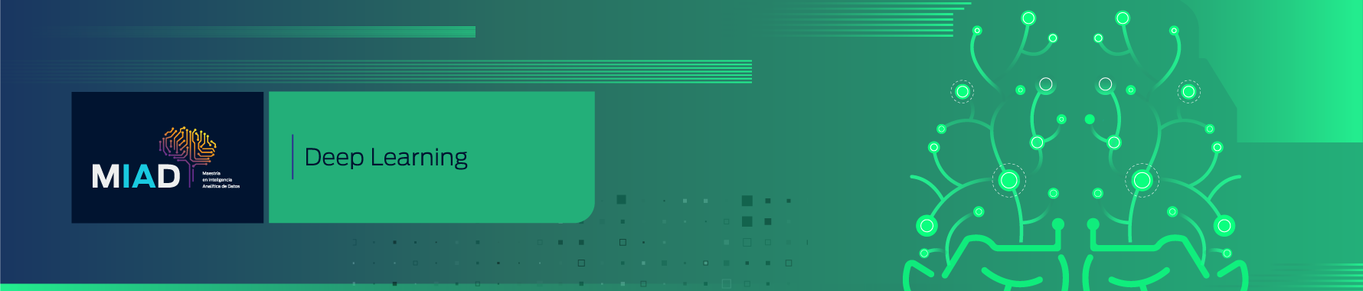

# Deep learning - Semana 4: Regularización y calibración en Deep Learning
## Redes neuronales: Regularización en redes neuronales (penalización norma 2)

### Propósito

En este _notebook_ se implementará la estrategia de penalización en norma 2 _(ridge)_ en una red neuronal de una capa usando el código que hemos desarrollado durante el curso. Se entenderá comó incluir la penalización en la función de pérdida que se quiere minimizar y cómo calcular los gradientes incluyendo la norma 2. 


### Instrucciones generales

1. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook. Sin embargo, siéntase libre de modificar el archivo editando las celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.  

2. Recuerde que para esta actividad NO necesita realizar ningún tipo de entrega.

### Librerías a importar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

### Datos 
En este notebook se usan los mismos datos de imágenes para autenticación de documentos bancarios que se han usado antes, los cuales fueron extraídos de imágenes tomadas de billetes. Para su digitalización, se utilizó una cámara industrial usada para la impresión. Luego, las imágenes de 400x400 pixeles se sometieron a un procedimiento de transformación de onda (Wavelet transformation) con la intención de extraer los features para la predicción. En este contexto, la variable de respuesta corresponde a si un billete es auténtico (y=1) o si no lo es (y=0) y las variables predictivas son las siguientes:

1. *variance* *of* *Wavelet* *Transformed* *image* *(continuous)*
2. *skewness* *of* *Wavelet* *Transformed* *image* *(continuous)*
3. *curtosis* *of* *Wavelet* *Transformed* *image* *(continuous)*
4. *entropy* *of* *image* *(continuous)*

In [2]:
data = np.genfromtxt('data_banknote_authentication.txt', delimiter = ',')
X = data[:,:4]
y = data[:, 4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

Las definiciones de estructuras, inicialización, funciones de activación, _forward propagation_ y la función de pérdida (entropía cruzada) antes de la penalización, se mantienen iguales a las utilizadas en notebooks previos:

In [3]:
def estructuras(X, Y):
    input_unit = X.shape[1] # Dimensión de entrada
    hidden_unit = 4 # Unidades de capa oculta
    output_unit = Y.shape[1] # Dimensión de variable de salida
    return (input_unit, hidden_unit, output_unit)
(input_unit, hidden_unit, output_unit) = estructuras(X_train, y_train)

def inicializacion(input_unit, hidden_unit, output_unit):
    np.random.seed(2) 
    W1 = np.random.randn(input_unit, hidden_unit)*0.01
    b1 = np.zeros((1, hidden_unit))
    W2 = np.random.randn(hidden_unit, output_unit)*0.01
    b2 = np.zeros((1, output_unit))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters


def sigmoid(z):
    return 1/(1+np.exp(-z))


def forward_propagation(X, parameters):
    
    W1 = parameters['W1'] #Valor de los pesos de la primera capa
    b1 = parameters['b1'] #Valor de los interceptos de la primera capa
    W2 = parameters['W2'] #Valor de los pesos de la salida
    b2 = parameters['b2'] #Valor de los interceptos de la salida
    
    Z1 = np.dot(X, W1) + b1 #Cálculo de la transformación afín de la primera capa
    A1 = sigmoid(Z1) #Evaluación de la función sigmoide de la primera capa
    Z2 = np.dot(A1, W2) + b2 #Cálculo de la transformación afín de la salida
    A2 = sigmoid(Z2) #Evaluación de la función sigmoide de la salida
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2}
    return A2, cache


def cross_entropy_cost(A2, Y, parameters):
    # Muestras de entrenamiento
    n = Y.shape[0] 
    # Calcular cross entropy
    logprobs = np.multiply(np.log(A2), Y) + np.multiply((1-Y), np.log(1 - A2))
    cost = - np.sum(logprobs) / n
    cost = float(np.squeeze(cost))    
    return cost

La función que se busca minimizar en términos de los parámetros $b$ y $W$ contiene el término de regularización. Supongamos en este caso que se penalizan los parámetros $W^{[1]}$, es decir, los que transforman los _inputs_ ($X$) a la primera capa de nodos ocultos. En este caso queda como:

$$ L_{reg}(W,b) = L(b,w_1,..., w_m)  + {\lambda\over 2n} \|W^{[1]}\|^2_F  $$

Donde $L(\cdot)$ es la función de entropía cruzada (función de pérdida antes de penalizar). Esto se ve reflejado en el cálculo de los gradientes que se usan en la etapa de propagación hacia atrás (_back propagation_).  En este caso, el gradiente de la función penalizada $L_{reg}(\cdot)$ respecto $W^{[1]}$ se puede calcular como:

$$ \nabla L_{reg}(W^{[1]}) = \nabla L(W^{[1]}) + {\lambda\over n}W^{[1]} $$

Lo que implica que al momento de actualizar los parámetros, se obtiene:

$$ W^{[1]}(t)  = W^{[1]}(t-1) - \alpha \nabla L_{reg}(W^{[1]}(t-1)) $$

In [4]:
def backward_propagation(parameters, cache, X, Y, pen = 0.5):
    
    n = X.shape[0]
    W1 = parameters['W1']
    W2 = parameters['W2']
    A1 = cache['A1']
    A2 = cache['A2']
    dZ2 = (1/n) *(A2-Y)
    dW2 = np.dot(A1.T,dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dZ1 = np.multiply(np.dot(dZ2,W2.T), A1 - np.power(A1, 2))
    dW1 = np.dot(X.T,dZ1) + pen/n*W1
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2,"db2": db2}
    return grads


def gradient_descent(parameters, grads, learning_rate = 0.01):
    #Se capturan los valores actuales para los parámetros de la red neuronal
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    #Se capturan los valores del gradiente para cada una de sus componentes
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    #Se actualizan los valores de los parámetros siguiendo la dirección contraria del gradiente
    W1 = W1 - learning_rate * dW1 
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1,"W2": W2,"b2": b2}
    
    return parameters

In [5]:
def neural_network_model(X, Y, hidden_unit, pen=0.5, num_iterations = 10000):
    np.random.seed(3)
    
    input_unit = estructuras(X, Y)[0]
    output_unit = estructuras(X, Y)[2]
    
    #Se inicializan los parámetros de manera aleatoria
    parameters = inicializacion(input_unit, hidden_unit, output_unit)
   
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    costs=[]
    
    
    for i in range(0, num_iterations):
                
        A2, cache = forward_propagation(X, parameters) #Se calcula la salida de la red para los datos utilizados y los valores de los parámetros para cada iteración
        
        cost = cross_entropy_cost(A2, Y, parameters) #Se calcula la función de costos
        
        costs.append(cost) #Se guardan el valor de la función de costos para cada iteración
        
        grads = backward_propagation(parameters, cache, X, Y, pen) #Se calcula el gradiente de la función de costos utilizando el método de backpropagation para cada iteración
        
        parameters = gradient_descent(parameters, grads) #Se actualiza el valor de los parámetros de acuerdo al gradiente calculado en cada iteración
        if i % 5 == 0:
            print ("Costo en la iteracion  %i: %f" %(i, cost))
    return parameters, costs

parameters, costs = neural_network_model(X_train, y_train, 4, 1, num_iterations=15000)

Costo en la iteracion  0: 0.693278
Costo en la iteracion  5: 0.692962
Costo en la iteracion  10: 0.692662
Costo en la iteracion  15: 0.692376
Costo en la iteracion  20: 0.692103
Costo en la iteracion  25: 0.691843
Costo en la iteracion  30: 0.691594
Costo en la iteracion  35: 0.691355
Costo en la iteracion  40: 0.691127
Costo en la iteracion  45: 0.690909
Costo en la iteracion  50: 0.690699
Costo en la iteracion  55: 0.690497
Costo en la iteracion  60: 0.690303
Costo en la iteracion  65: 0.690116
Costo en la iteracion  70: 0.689935
Costo en la iteracion  75: 0.689761
Costo en la iteracion  80: 0.689592
Costo en la iteracion  85: 0.689429
Costo en la iteracion  90: 0.689270
Costo en la iteracion  95: 0.689116
Costo en la iteracion  100: 0.688966
Costo en la iteracion  105: 0.688820
Costo en la iteracion  110: 0.688677
Costo en la iteracion  115: 0.688537
Costo en la iteracion  120: 0.688400
Costo en la iteracion  125: 0.688266
Costo en la iteracion  130: 0.688134
Costo en la iteracion  

### Evaluación de predicciones en muestra de _test:_

In [6]:
def prediction(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    return predictions

predictions = prediction(parameters, X_train)
print ('Accuracy Train: %d' % float((np.dot(y_train.T, predictions) + np.dot(1 - y_train.T, 1 - predictions))/float(y_train.size)*100) + '%')
predictions = prediction(parameters, X_test)
print ('Accuracy Test: %d' % float((np.dot(y_test.T, predictions) + np.dot(1 - y_test.T, 1 - predictions))/float(y_test.size)*100) + '%')

Accuracy Train: 98%
Accuracy Test: 98%


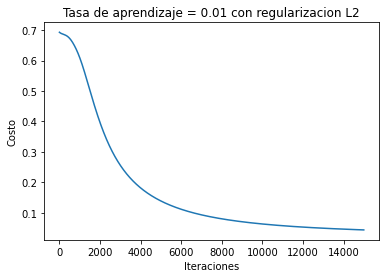

In [7]:
plt.plot(costs)
plt.ylabel('Costo')
plt.xlabel('Iteraciones')
plt.title("Tasa de aprendizaje = 0.01 con regularizacion L2" )
plt.show()

### Ejercicio no evaluable

Pruebe diferentes valores para el parámetro de penalización $\lambda$ y para la tasa de aprendizaje $\alpha$ para encontrar un mejor desempeño en la muestra de _test_.